In [0]:
# Cell 1 — Imports & load
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import pandas as pd

# Load the table you uploaded
table_name = "workspace.default.agri_big_data_3000"
df = spark.table(table_name)
# normalize columns
for c in df.columns:
    df = df.withColumnRenamed(c, c.strip().lower().replace(" ", "_"))

print("Loaded columns:", df.columns)
display(df.limit(5))


Loaded columns: ['region', 'crop', 'emotion', 'post_text', 'date', 'sentiment_score', 'price', 'demand_index', 'temperature', 'rainfall']


region,crop,emotion,post_text,date,sentiment_score,price,demand_index,temperature,rainfall
Gujarat,Wheat,Positive,wilt,2025-03-04,0,4562.48,136,34.81,10.91
Maharashtra,Pulses,Positive,pest attack,2025-01-24,1,4731.54,63,31.22,14.32
Gujarat,Pulses,Happy,borer,2025-05-31,1,5221.2,157,36.12,13.96
Telangana,Sugarcane,Neutral,blight,2025-03-28,0,3715.47,95,36.95,12.07
Punjab,Rice,Angry,healthy crop,2025-02-01,-1,9636.1,110,25.86,12.57


In [0]:
# Cell 2 — canonical fields & enrichment
# Ensure event timestamp
if "date" in df.columns:
    df = df.withColumn("event_ts", F.to_timestamp("date"))
else:
    df = df.withColumn("event_ts", F.current_timestamp())

# Ensure commonly used columns exist (create nulls if missing)
for colname in ["crop","region","post_text","emotion","sentiment_score","price","demand_index","temperature","rainfall"]:
    if colname not in df.columns:
        # numeric fields as double, text as string
        dtype = "double" if colname in ["sentiment_score","price","demand_index","temperature","rainfall"] else "string"
        df = df.withColumn(colname, F.lit(None).cast(dtype))

# normalize emotion -> emotion_norm
df = df.withColumn("emotion_norm", F.lower(F.coalesce(F.col("emotion"), F.lit(""))))

# if sentiment_score missing, derive from emotion_norm
if df.filter(F.col("sentiment_score").isNotNull()).count() == 0:
    df = df.withColumn(
        "sentiment_score",
        F.when(F.col("emotion_norm").rlike("positive|happy|joy|optimistic"), 1)
         .when(F.col("emotion_norm").rlike("negative|sad|angry|fear|frustrated"), -1)
         .otherwise(0)
    )
df = df.withColumn("sentiment_score", F.col("sentiment_score").cast("double"))
df = df.withColumn("sentiment_label",
                   F.when(F.col("sentiment_score")>0,"positive")
                    .when(F.col("sentiment_score")<0,"negative")
                    .otherwise("neutral"))

# If price is null everywhere, generate synthetic demo prices
if df.filter(F.col("price").isNotNull()).count() == 0:
    print("No price data found — generating synthetic prices for demo")
    df = df.withColumn("price", (F.rand()*3000 + 4000) + F.col("sentiment_score")*F.rand()*200)

# cast numeric columns
df = df.withColumn("price", F.col("price").cast("double"))
if "demand_index" in df.columns:
    df = df.withColumn("demand_index", F.col("demand_index").cast("double"))
if "temperature" in df.columns:
    df = df.withColumn("temperature", F.col("temperature").cast("double"))
if "rainfall" in df.columns:
    df = df.withColumn("rainfall", F.col("rainfall").cast("double"))

# register canonical view
df.createOrReplaceTempView("agri_canonical")
print("Canonical view 'agri_canonical' ready.")
display(df.select("region","crop","post_text","emotion_norm","sentiment_score","price").limit(10))


Canonical view 'agri_canonical' ready.


region,crop,post_text,emotion_norm,sentiment_score,price
Gujarat,Wheat,wilt,positive,0.0,4562.48
Maharashtra,Pulses,pest attack,positive,1.0,4731.54
Gujarat,Pulses,borer,happy,1.0,5221.2
Telangana,Sugarcane,blight,neutral,0.0,3715.47
Punjab,Rice,healthy crop,angry,-1.0,9636.1
Punjab,Soybean,disease,happy,-1.0,7374.23
Tamil Nadu,Sugarcane,aphid,angry,-1.0,5449.37
Karnataka,Maize,infection,happy,1.0,5954.09
Telangana,Rice,pest attack,happy,0.0,5808.15
Gujarat,Millets,borer,fear,1.0,5003.49


In [0]:
# USE CASE 1: Early Warning System (Pest/Disease) — All Regions



# Cell 3 — Use Case 1: pest detection + anomaly detection
df = spark.table("agri_canonical")

# pest keywords (extend if you want)
pest_keywords = ["pest","disease","infection","infestation","attack","rot","fungus","aphid","wilt","blight","rust","borer","damage","crop_loss","insect"]
regex = "|".join([rf"(?i)\b{k}\b" for k in pest_keywords])

df = df.withColumn("pest_flag", F.when(F.col("crop").rlike(regex) | F.col("post_text").rlike(regex) | F.col("emotion_norm").rlike(regex), 1).otherwise(0))

# daily aggregation by region
daily = (df.withColumn("day", F.date_trunc("day","event_ts"))
           .groupBy("region","day")
           .agg(
               F.count("*").alias("total_posts"),
               F.sum("pest_flag").alias("pest_mentions"),
               F.avg("sentiment_score").alias("avg_sentiment"),
               F.avg("price").alias("avg_price")
           )
        )

# rolling 3-day window, safe division
w = Window.partitionBy("region").orderBy("day").rowsBetween(-2,0)
daily = (daily.withColumn("mean_3d", F.avg("pest_mentions").over(w))
               .withColumn("std_3d", F.stddev("pest_mentions").over(w))
               .withColumn("z_score", F.when(F.col("std_3d")>0, (F.col("pest_mentions")-F.col("mean_3d"))/F.col("std_3d")).otherwise(F.lit(0)))
               .withColumn("pest_anomaly", F.when(F.col("z_score")>1.0, True).otherwise(False))
        )

daily.createOrReplaceTempView("agri_pest_allregions")
print("agri_pest_allregions temp view created.")
# Show regions with any pest mentions
display(daily.filter("pest_mentions > 0").orderBy(F.desc("pest_mentions")).limit(200))


agri_pest_allregions temp view created.


region,day,total_posts,pest_mentions,avg_sentiment,avg_price,mean_3d,std_3d,z_score,pest_anomaly
Tamil Nadu,2025-04-10T00:00:00.000Z,9,8,-0.4444444444444444,6925.5233333333335,3.6666666666666665,3.785938897200183,1.1445861782233109,true
Telangana,2025-03-05T00:00:00.000Z,7,7,-0.14285714285714285,6085.115714285715,3.6666666666666665,2.8867513459481287,1.1547005383792517,true
Punjab,2025-02-08T00:00:00.000Z,8,7,-0.625,5503.157499999999,5.0,2.0,1.0,false
Tamil Nadu,2025-01-04T00:00:00.000Z,6,6,0.16666666666666666,6783.855,3.6666666666666665,2.0816659994661326,1.1208970766356101,true
Gujarat,2025-03-17T00:00:00.000Z,7,6,0.0,6531.148571428573,4.666666666666667,2.3094010767585034,0.5773502691896255,false
Telangana,2025-06-12T00:00:00.000Z,6,6,-0.16666666666666666,7874.159999999999,3.0,2.6457513110645907,1.1338934190276817,true
Gujarat,2025-06-09T00:00:00.000Z,6,6,0.16666666666666666,6131.764999999999,3.6666666666666665,2.0816659994661326,1.1208970766356101,true
Gujarat,2025-01-25T00:00:00.000Z,6,6,0.0,8012.001666666666,4.0,1.7320508075688772,1.1547005383792517,true
Karnataka,2025-04-25T00:00:00.000Z,7,6,0.0,7065.532857142857,4.0,2.0,1.0,false
Tamil Nadu,2025-03-24T00:00:00.000Z,7,6,0.0,6585.657142857142,2.6666666666666665,2.8867513459481287,1.1547005383792517,true


Databricks visualization. Run in Databricks to view.

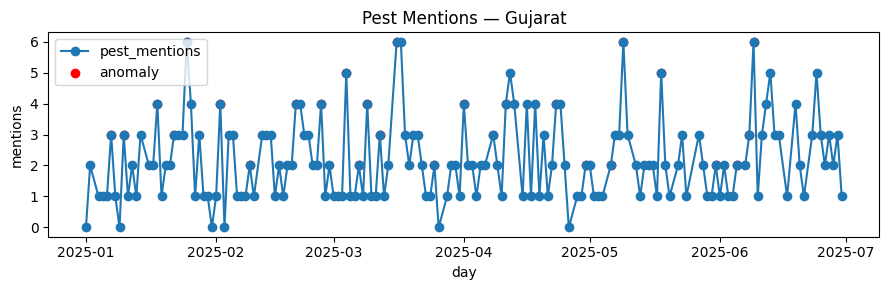

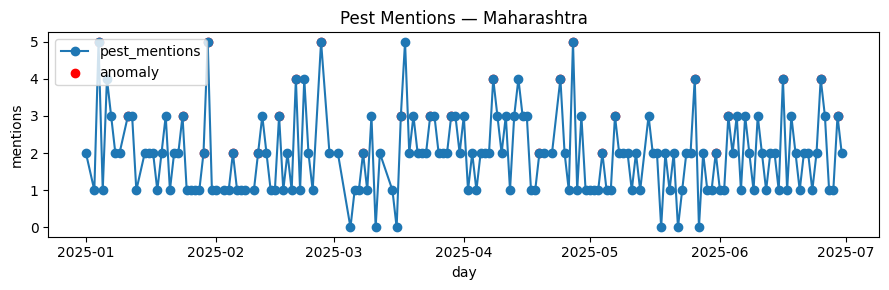

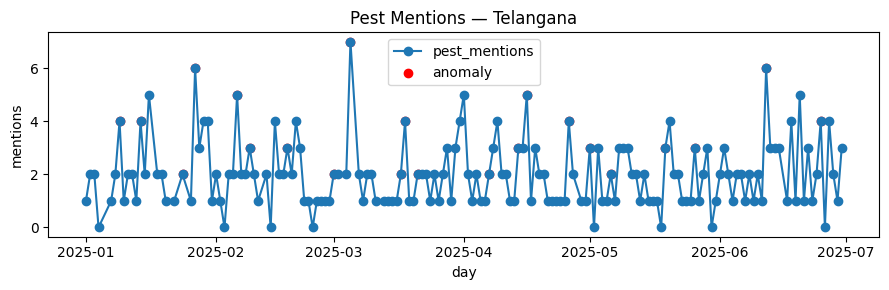

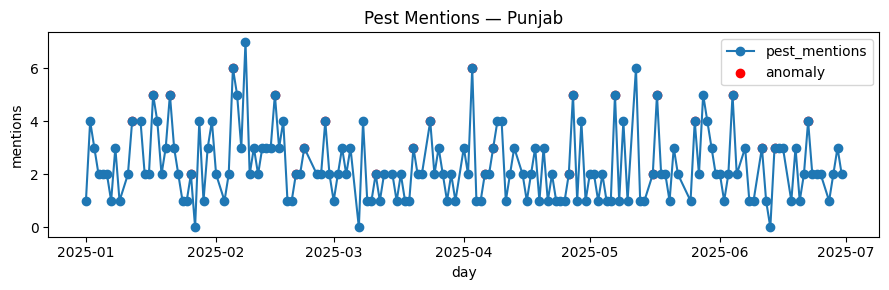

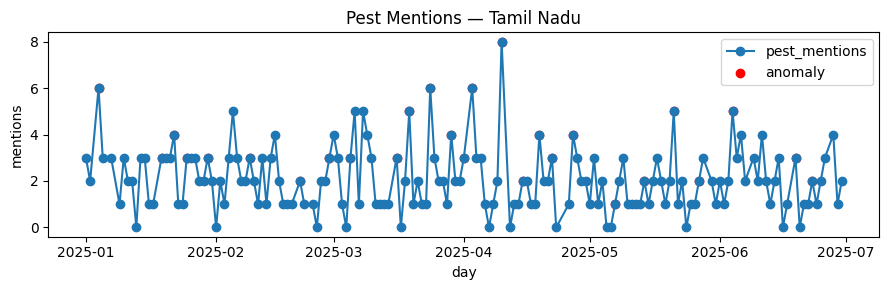

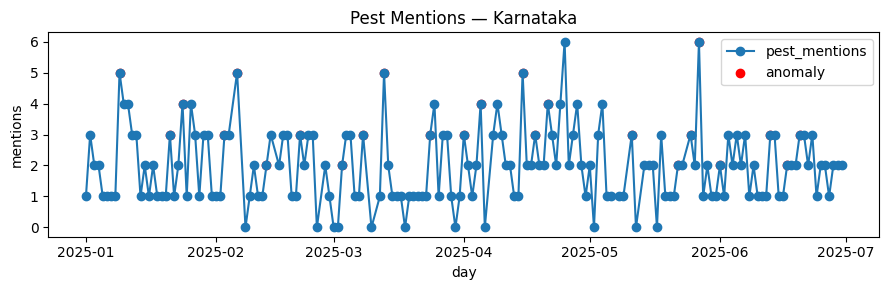

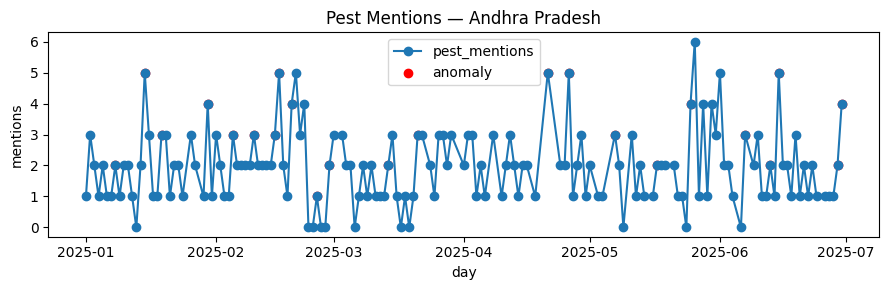

In [0]:
# Plot pest mentions and anomalies for each region
daily_local = spark.table("agri_pest_allregions")
regions = [r.region for r in daily_local.select("region").distinct().collect()]
for region in regions:
    pdf = daily_local.filter(F.col("region")==region).orderBy("day").toPandas()
    if pdf.empty: 
        continue
    plt.figure(figsize=(9,3))
    plt.plot(pdf['day'], pdf['pest_mentions'], marker='o', label='pest_mentions')
    anomalous = pdf[pdf['pest_anomaly']==True] if 'pest_anomaly' in pdf.columns else pd.DataFrame()
    if not anomalous.empty:
        plt.scatter(anomalous['day'], anomalous['pest_mentions'], color='red', label='anomaly')
    plt.title(f"Pest Mentions — {region}")
    plt.xlabel("day"); plt.ylabel("mentions"); plt.legend(); plt.tight_layout(); plt.show()


In [0]:
# Cell 4 — Streaming scaffold (template, not executed automatically)
# Replace with your streaming source (Kafka/Event Hubs). This is a scaffold showing how to integrate structured streaming.

# Example (commented):
# from pyspark.sql.types import StructType, StructField, StringType, DoubleType, TimestampType
# schema = StructType([...])  # define schema for incoming JSON messages
# stream_raw = spark.readStream.format("kafka") \
#     .option("kafka.bootstrap.servers","<BROKER>") \
#     .option("subscribe","agri_topic") \
#     .load()
# parsed = stream_raw.selectExpr("CAST(value AS STRING) as json_str")
# parsed = parsed.select(from_json("json_str", schema).alias("data")).select("data.*")
# # apply same transformations as batch: emotion_norm, pest_flag, etc.
# # write to memory sink for dashboard:
# # parsed.writeStream.format("memory").queryName("stream_agri").start()
print("Streaming scaffold provided. Configure your live source and the same transforms as the batch pipeline.")


Streaming scaffold provided. Configure your live source and the same transforms as the batch pipeline.


In [0]:
# USE CASE 2: Real-Time Commodity Price Nowcasting (Spark ML baseline)

# Cell 5 — Use Case 2: price nowcasting
df = spark.table("agri_canonical")

features = (df.withColumn("day", F.date_trunc("day","event_ts"))
              .groupBy("crop","day")
              .agg(
                  F.avg("sentiment_score").alias("avg_sent"),
                  F.count("*").alias("posts"),
                  F.avg("price").alias("avg_price"),
                  F.avg("demand_index").alias("avg_demand")
              ))

w = Window.partitionBy("crop").orderBy("day")
features = features.withColumn("next_price", F.lead("avg_price").over(w))
features = features.withColumn("price_change", F.col("next_price") - F.col("avg_price"))

train = features.filter(F.col("next_price").isNotNull()).na.drop()
if train.count() < 10:
    print("Not enough rows for training. Displaying features sample.")
    display(features.orderBy("crop","day").limit(100))
else:
    assembler = VectorAssembler(inputCols=["avg_sent","posts","avg_demand"], outputCol="features")
    rf = RandomForestRegressor(featuresCol="features", labelCol="price_change", numTrees=40, maxDepth=6)
    pipeline = Pipeline(stages=[assembler, rf])
    model = pipeline.fit(train)
    preds = model.transform(train)
    display(preds.select("crop","day","avg_price","next_price","prediction").orderBy("crop","day").limit(200))
    # quick MSE
    mse = preds.select(F.mean(F.pow(F.col("prediction")-F.col("price_change"),2)).alias("mse")).collect()[0]["mse"]
    print(f"Baseline RF MSE: {mse:.4f}")


crop,day,avg_price,next_price,prediction
Cotton,2025-01-02T00:00:00.000Z,8003.86,9496.67,-304.30043507091534
Cotton,2025-01-03T00:00:00.000Z,9496.67,6038.776666666666,-103.62018549107475
Cotton,2025-01-04T00:00:00.000Z,6038.776666666666,7242.44,-119.81216436849033
Cotton,2025-01-06T00:00:00.000Z,7242.44,7014.9580000000005,-920.1096390308206
Cotton,2025-01-07T00:00:00.000Z,7014.9580000000005,4514.48,24.36172543345206
Cotton,2025-01-08T00:00:00.000Z,4514.48,4972.233333333334,200.76446110833356
Cotton,2025-01-11T00:00:00.000Z,4972.233333333334,6863.165,84.38675606243287
Cotton,2025-01-12T00:00:00.000Z,6863.165,5655.17,304.5150360185242
Cotton,2025-01-14T00:00:00.000Z,5655.17,5965.889999999999,-90.65845473223946
Cotton,2025-01-15T00:00:00.000Z,5965.889999999999,3617.73,-327.3522874539193


Databricks visualization. Run in Databricks to view.

Baseline RF MSE: 4508452.6888


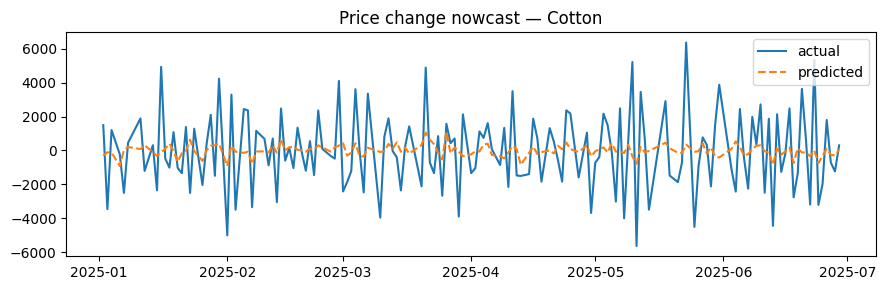

In [0]:
# plot predicted vs actual price change for one crop
preds_local = preds if 'preds' in globals() else None
if preds_local is not None:
    crop_choice = preds_local.select("crop").distinct().limit(1).collect()[0]['crop']
    pdf = preds_local.filter(F.col("crop")==crop_choice).orderBy("day").toPandas()
    if not pdf.empty:
        plt.figure(figsize=(9,3))
        plt.plot(pdf['day'], pdf['price_change'], label='actual')
        plt.plot(pdf['day'], pdf['prediction'], linestyle='--', label='predicted')
        plt.title(f"Price change nowcast — {crop_choice}"); plt.legend(); plt.tight_layout(); plt.show()


In [0]:
# USE CASE 3: Farmer Sentiment Monitoring (region dashboard)

# Cell 6 — Sentiment monitoring
df = spark.table("agri_canonical")
sent_region = (df.groupBy("region")
                .agg(
                    F.count("*").alias("posts"),
                    F.avg("sentiment_score").alias("avg_sent"),
                    F.sum(F.when(F.col("sentiment_score")>0,1).otherwise(0)).alias("pos"),
                    F.sum(F.when(F.col("sentiment_score")<0,1).otherwise(0)).alias("neg")
                )
                .withColumn("neg_ratio", F.round(F.col("neg")/F.col("posts"),3))
               )
sent_region.createOrReplaceTempView("agri_sentiment_region")
display(sent_region.orderBy("avg_sent"))


region,posts,avg_sent,pos,neg,neg_ratio
Telangana,430,-0.018604651162790697,129,137,0.319
Maharashtra,396,-0.015151515151515152,115,121,0.306
Tamil Nadu,440,-0.004545454545454545,135,137,0.311
Andhra Pradesh,394,-0.0025380710659898475,122,123,0.312
Karnataka,434,0.002304147465437788,125,124,0.286
Gujarat,447,0.0044742729306487695,134,132,0.295
Punjab,459,0.015250544662309368,146,139,0.303


Databricks visualization. Run in Databricks to view.

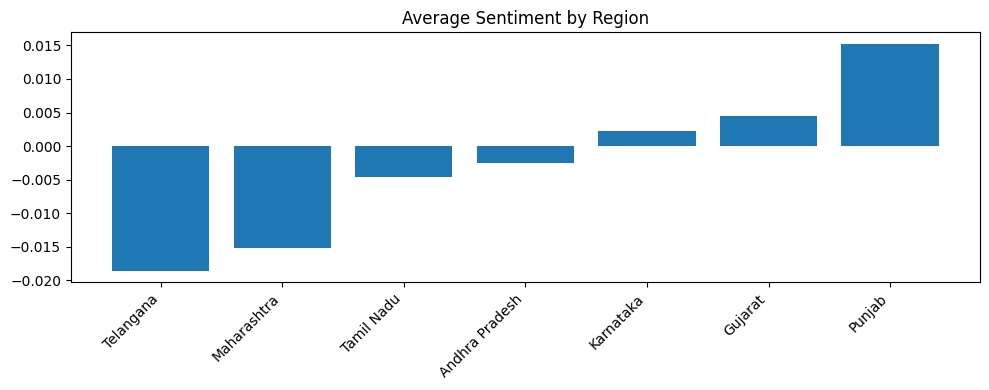

In [0]:
pdf = sent_region.toPandas().sort_values("avg_sent")
plt.figure(figsize=(10,4))
plt.bar(pdf['region'], pdf['avg_sent'])
plt.xticks(rotation=45, ha='right'); plt.title("Average Sentiment by Region"); plt.tight_layout(); plt.show()


In [0]:
# USE CASE 4: Market Demand Prediction (clustering + simple forecast)

# Cell 7 — Market demand clustering + optional posts forecasting
df = spark.table("agri_canonical")
demand = (df.groupBy("region","crop")
            .agg(
                F.count("*").alias("posts"),
                F.avg("sentiment_score").alias("avg_sent"),
                F.avg("price").alias("avg_price"),
                F.avg("demand_index").alias("avg_demand")
            ).na.fill(0)
         )

va = VectorAssembler(inputCols=["avg_sent","avg_price","posts","avg_demand"], outputCol="vec")
vec_df = va.transform(demand)
scaler = StandardScaler(inputCol="vec", outputCol="scaled")
scaled_df = scaler.fit(vec_df).transform(vec_df)
kmeans = KMeans(k=4, featuresCol="scaled", seed=42)
km_model = kmeans.fit(scaled_df)
clusters = km_model.transform(scaled_df).select("region","crop","posts","avg_sent","avg_price","avg_demand","prediction")
display(clusters.limit(100))

# Optional simple posts -> next_posts linear regression if daily points exist
daily_posts = (df.withColumn("day", F.date_trunc("day","event_ts"))
                 .groupBy("region","crop","day")
                 .agg(F.count("*").alias("posts"))
               )
w = Window.partitionBy("region","crop").orderBy("day")
daily_posts = daily_posts.withColumn("next_posts", F.lead("posts").over(w))
train_dp = daily_posts.filter(F.col("next_posts").isNotNull()).na.drop()
if train_dp.count() > 10:
    assembler = VectorAssembler(inputCols=["posts"], outputCol="features")
    lr = LinearRegression(featuresCol="features", labelCol="next_posts")
    model_dp = lr.fit(assembler.transform(train_dp))
    dp_preds = model_dp.transform(assembler.transform(train_dp))
    display(dp_preds.select("region","crop","day","posts","next_posts","prediction").limit(50))
else:
    print("Not enough consecutive daily points for demand regression; use clusters for insights.")


region,crop,posts,avg_sent,avg_price,avg_demand,prediction
Gujarat,Wheat,57,0.07017543859649122,6729.6535087719285,94.19298245614036,2
Maharashtra,Pulses,50,0.04,6658.280400000001,98.26,3
Gujarat,Pulses,55,0.03636363636363636,6362.015636363637,100.21818181818182,3
Telangana,Sugarcane,67,-0.11940298507462686,6388.500746268658,102.6268656716418,0
Punjab,Rice,66,-0.045454545454545456,6383.133787878787,98.74242424242425,0
Punjab,Soybean,57,-0.017543859649122806,6064.914736842106,100.80701754385964,0
Tamil Nadu,Sugarcane,53,0.07547169811320754,6887.639999999999,97.58490566037736,2
Karnataka,Maize,63,0.047619047619047616,6745.49634920635,101.6984126984127,2
Telangana,Rice,58,0.034482758620689655,6472.741034482761,99.77586206896552,3
Gujarat,Millets,51,-0.09803921568627451,6487.383137254904,106.52941176470588,3


Databricks visualization. Run in Databricks to view.

region,crop,day,posts,next_posts,prediction
Andhra Pradesh,Cotton,2025-01-02T00:00:00.000Z,1,2,1.16055443361988
Andhra Pradesh,Cotton,2025-01-11T00:00:00.000Z,2,2,1.1833243900758856
Andhra Pradesh,Cotton,2025-01-15T00:00:00.000Z,2,1,1.1833243900758856
Andhra Pradesh,Cotton,2025-01-16T00:00:00.000Z,1,1,1.16055443361988
Andhra Pradesh,Cotton,2025-01-27T00:00:00.000Z,1,1,1.16055443361988
Andhra Pradesh,Cotton,2025-02-07T00:00:00.000Z,1,1,1.16055443361988
Andhra Pradesh,Cotton,2025-02-15T00:00:00.000Z,1,2,1.16055443361988
Andhra Pradesh,Cotton,2025-02-16T00:00:00.000Z,2,1,1.1833243900758856
Andhra Pradesh,Cotton,2025-02-21T00:00:00.000Z,1,1,1.16055443361988
Andhra Pradesh,Cotton,2025-02-22T00:00:00.000Z,1,1,1.16055443361988


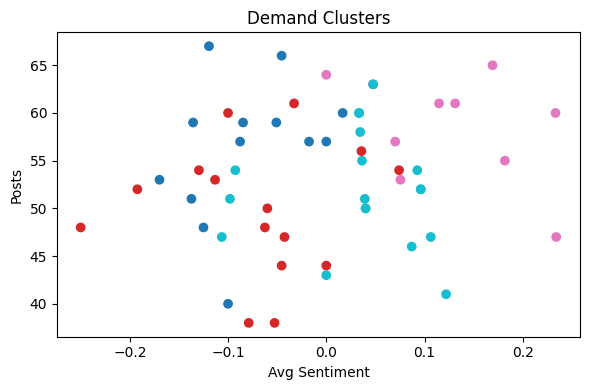

In [0]:
pdf = clusters.toPandas()
plt.figure(figsize=(6,4))
plt.scatter(pdf['avg_sent'], pdf['posts'], c=pdf['prediction'], cmap='tab10')
plt.xlabel('Avg Sentiment'); plt.ylabel('Posts'); plt.title('Demand Clusters'); plt.tight_layout(); plt.show()


In [0]:
# USE CASE 5: Regional Alert & Recommendation System

# Cell 8 — Alerts combining pest anomalies + low sentiment + price drops
daily = spark.table("agri_pest_allregions")  # temp view from earlier
sent_region = spark.table("agri_sentiment_region")  # temp view
# Build pest alerts
alerts_pest = daily.filter("pest_anomaly = true").select("region","day","pest_mentions","z_score","avg_sentiment") \
                   .withColumn("alert_reason", F.lit("Pest Spike")) \
                   .withColumn("severity", F.when(F.col("pest_mentions")>5,"high").otherwise("medium")) \
                   .withColumn("recommendation", F.when(F.col("avg_sentiment")<0, F.lit("Dispatch pest-control & advisories")).otherwise(F.lit("Monitor")))

# Build sentiment alerts
alerts_sent = sent_region.filter("avg_sent < 0").select("region","avg_sent") \
                         .withColumn("day", F.lit(None).cast("timestamp")) \
                         .withColumn("alert_reason", F.lit("Low Farmer Sentiment")) \
                         .withColumn("severity", F.lit("medium")) \
                         .withColumn("recommendation", F.lit("Engage farmers via support programs"))

final_alerts = alerts_pest.select("region","day","alert_reason","severity","recommendation").unionByName(alerts_sent.select("region","day","alert_reason","severity","recommendation"), allowMissingColumns=True)

display(final_alerts.orderBy("severity","region"))


region,day,alert_reason,severity,recommendation
Gujarat,2025-01-25T00:00:00.000Z,Pest Spike,high,Monitor
Gujarat,2025-03-16T00:00:00.000Z,Pest Spike,high,Dispatch pest-control & advisories
Gujarat,2025-06-09T00:00:00.000Z,Pest Spike,high,Monitor
Gujarat,2025-05-09T00:00:00.000Z,Pest Spike,high,Dispatch pest-control & advisories
Karnataka,2025-05-27T00:00:00.000Z,Pest Spike,high,Monitor
Punjab,2025-04-03T00:00:00.000Z,Pest Spike,high,Dispatch pest-control & advisories
Punjab,2025-02-05T00:00:00.000Z,Pest Spike,high,Monitor
Tamil Nadu,2025-01-04T00:00:00.000Z,Pest Spike,high,Monitor
Tamil Nadu,2025-04-10T00:00:00.000Z,Pest Spike,high,Dispatch pest-control & advisories
Tamil Nadu,2025-03-24T00:00:00.000Z,Pest Spike,high,Monitor


Databricks visualization. Run in Databricks to view.